<a href="https://colab.research.google.com/github/hpv8hfuva/AVLTree/blob/master/hpv8hf_codeathon_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CODEATHON 2: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](http://faculty.virginia.edu/lazzara/images/UVAgrounds.jpg) 

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture. 

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 10 bonus points if (1) your classifier performs exceed 95% accuracy OR you try at least 3 different architectures and able to analyze their performance.

To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Collab with the following format: yourcomputingID_codeathon_2.ipynb

Best of luck, and have fun! 

# Load Packages

In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(49)
tf.random.set_seed(49)

# Import Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [2]:
# Download dataset from Firebase
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

--2020-11-07 03:35:51--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 172.217.13.74, 2607:f8b0:4004:810::200a
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|172.217.13.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip?alt=media’

dataset.zip?alt=med 100%[===================>] 378.77M   152MB/s    in 2.5s    

2020-11-07 03:35:53 (152 MB/s) - ‘dataset.zip?alt=media’ saved [397174132/397174132]



In [3]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/dataset/Rotunda/._0000010694.jpg  
  inflating: dataset/Rotunda/0000010680.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010680.jpg  
  inflating: dataset/Rotunda/0000010858.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010858.jpg  
  inflating: dataset/Rotunda/0000010870.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010870.jpg  
  inflating: dataset/Rotunda/0000010864.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010864.jpg  
  inflating: dataset/Rotunda/0000010865.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010865.jpg  
  inflating: dataset/Rotunda/0000010871.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010871.jpg  
  inflating: dataset/Rotunda/0000010859.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010859.jpg  
  inflating: dataset/Rotunda/0000010681.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010681.jpg  
  inflating: dataset/Rotunda/0000010695.jpg  
  inflating: __MACOSX/

In [4]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 160; 
img_width = 160;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 49,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Test Dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 49,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        

Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


In [5]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

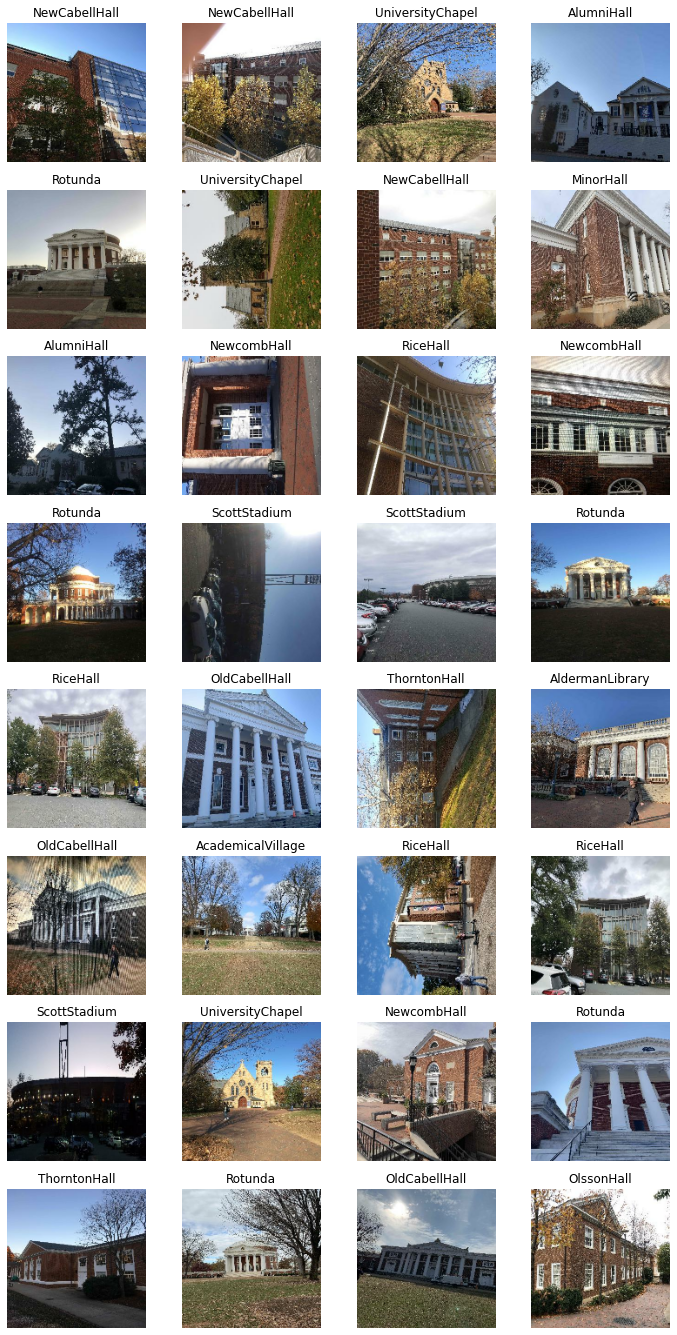

In [6]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


# It's your turn: Building a classifier for UVA Landmark Dataset
You may design your own architecture OR re-use any of the exising frameworks. 

Best of luck!

In [7]:
 #create validation set from test set
 #validation_ds = test_ds.take(int(len(test_ds) / 2))
 #new_test_ds = test_ds.skip(int(len(test_ds) / 2))
 val_batches = tf.data.experimental.cardinality(test_ds)
 new_test_ds = test_ds.take(val_batches // 2)
 validation_ds = test_ds.skip(val_batches // 2)

 

In [8]:
import tensorflow as tf
from tensorflow import keras
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1), 
  ]
)

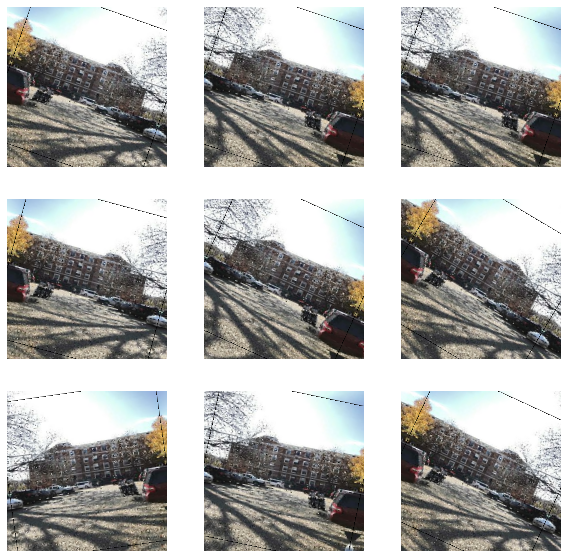

In [9]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [11]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [13]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(18, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 18)


In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
initial_epochs = 40

loss0, accuracy0 = model.evaluate(validation_ds)

45/45 [==============================] - 3s 60ms/step - loss: 2.8923 - accuracy: 0.0522


In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.89
initial accuracy: 0.05


In [20]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds)

Epoch 1/40
358/358 [==============================] - 31s 88ms/step - loss: 2.6242 - accuracy: 0.3903 - val_loss: 2.5152 - val_accuracy: 0.5201
Epoch 2/40
358/358 [==============================] - 31s 87ms/step - loss: 2.4635 - accuracy: 0.5497 - val_loss: 2.4640 - val_accuracy: 0.5596
Epoch 3/40
358/358 [==============================] - 30s 84ms/step - loss: 2.3996 - accuracy: 0.6119 - val_loss: 2.4117 - val_accuracy: 0.6196
Epoch 4/40
358/358 [==============================] - 30s 83ms/step - loss: 2.3712 - accuracy: 0.6365 - val_loss: 2.3834 - val_accuracy: 0.6366
Epoch 5/40
358/358 [==============================] - 30s 83ms/step - loss: 2.3543 - accuracy: 0.6512 - val_loss: 2.3826 - val_accuracy: 0.6380
Epoch 6/40
358/358 [==============================] - 30s 83ms/step - loss: 2.3004 - accuracy: 0.7163 - val_loss: 2.3207 - val_accuracy: 0.7100
Epoch 7/40
358/358 [==============================] - 30s 84ms/step - loss: 2.2646 - accuracy: 0.7516 - val_loss: 2.3080 - val_accuracy:

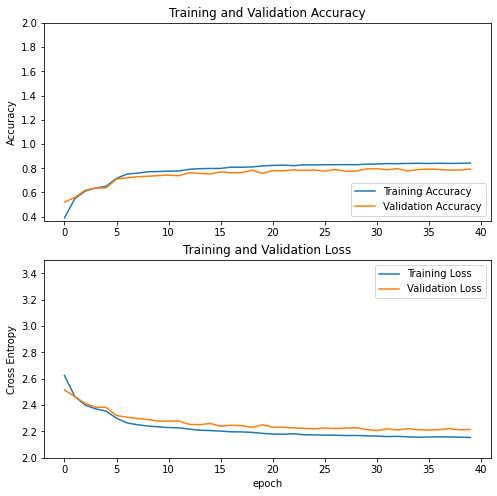

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),2])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([2,3.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [23]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [25]:
fine_tune_epochs = 60
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds)

Epoch 40/100
358/358 [==============================] - 32s 89ms/step - loss: 2.2167 - accuracy: 0.7703 - val_loss: 2.2883 - val_accuracy: 0.6944
Epoch 41/100
358/358 [==============================] - 31s 87ms/step - loss: 2.1701 - accuracy: 0.8159 - val_loss: 2.1688 - val_accuracy: 0.8158
Epoch 42/100
358/358 [==============================] - 31s 86ms/step - loss: 2.1470 - accuracy: 0.8380 - val_loss: 2.1427 - val_accuracy: 0.8384
Epoch 43/100
358/358 [==============================] - 31s 86ms/step - loss: 2.1292 - accuracy: 0.8561 - val_loss: 2.1216 - val_accuracy: 0.8624
Epoch 44/100
358/358 [==============================] - 31s 85ms/step - loss: 2.1177 - accuracy: 0.8660 - val_loss: 2.1272 - val_accuracy: 0.8560
Epoch 45/100
358/358 [==============================] - 30s 85ms/step - loss: 2.1042 - accuracy: 0.8812 - val_loss: 2.1296 - val_accuracy: 0.8504
Epoch 46/100
358/358 [==============================] - 30s 85ms/step - loss: 2.0962 - accuracy: 0.8876 - val_loss: 2.1242 -

In [26]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

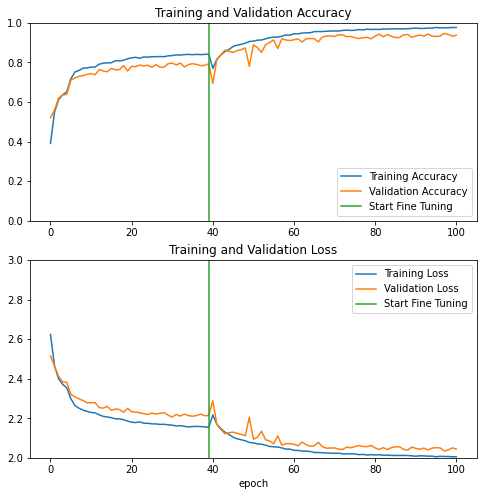

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([2, 3.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
fine_tune_epochs_two = 3
total_epochs =  initial_epochs + fine_tune_epochs + fine_tune_epochs_two

history_fine_2 = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=validation_ds)

Epoch 100/103
358/358 [==============================] - 31s 87ms/step - loss: 2.0026 - accuracy: 0.9794 - val_loss: 2.0424 - val_accuracy: 0.9379
Epoch 101/103
358/358 [==============================] - 31s 87ms/step - loss: 2.0015 - accuracy: 0.9806 - val_loss: 2.0394 - val_accuracy: 0.9428
Epoch 102/103
358/358 [==============================] - 31s 87ms/step - loss: 2.0018 - accuracy: 0.9801 - val_loss: 2.0699 - val_accuracy: 0.9125
Epoch 103/103
358/358 [==============================] - 31s 86ms/step - loss: 2.0019 - accuracy: 0.9801 - val_loss: 2.0380 - val_accuracy: 0.9442


**Final evaluation results**

In [38]:
loss, accuracy = model.evaluate(new_test_ds)
print('Test accuracy :', accuracy)

45/45 [==============================] - 3s 61ms/step - loss: 2.0280 - accuracy: 0.9549
Test accuracy : 0.9548611044883728
